<a href="https://colab.research.google.com/github/ComputerFinance/ESWA/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import os
os.chdir('/content')

In [2]:
!pip install -r 'requirements.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Success

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cvxopt as opt
from cvxopt import blas, solvers

import utils
indicators = utils.Indicators()

%matplotlib inline
plt.close('all')

plt.style.use("seaborn-whitegrid")

import warnings
warnings.filterwarnings('ignore')

solvers.options['show_progress'] = False

<ipython-input-3-7bde3da3d811>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Portfolio Optimization on MV, IVP and HRP

For the optimizations, we are based the implementations present in Prado (2016, 2018).

In [6]:
def getIVP(cov, **kargs):

    # Compute the inverse-variance portfolio
    ivp = 1.0 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov, cItems):

    # Compute variance per cluster
    cov_ = cov.loc[cItems, cItems]  # matrix slice
    w_ = getIVP(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar


def getQuasiDiag(link):

    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):

    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [
            i[j:k]
            for i in cItems
            for j, k in ((0, len(i) // 2), (len(i) // 2, len(i)))
            if len(i) > 1
        ]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def matrix_from_correlation(cov):

    vols = np.sqrt(np.diag(cov))
    corr = np.multiply(cov, np.outer(vols**-1, vols**-1))
    # deal with precision errors
    np.fill_diagonal(corr.values, 1)  # solve precision errors
    distances = np.sqrt((1 - corr) / 2)
    np.fill_diagonal(distances.values, 0)  # solve precision errors
    corr = pd.DataFrame(corr)
    return corr


def correlDist(corr):

    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.0) ** 0.5  # distance matrix
    return dist


def getHRP(cov):

    corr = matrix_from_correlation(cov)
    dist = correlDist(corr)
    link = sch.linkage(dist, "ward")
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()


def getMV(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)["x"] for mu in mus]
    ## Calculate Risks and Returns for Frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## Calculate the 2ND Degree Polynomial of the Frontier Curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)["x"]

    return list(wt)


In [8]:
def get_all_portfolios(returns):
    
    cov = returns.cov()
    hrp = getHRP(cov)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mv = getMV(cov)
    mv = pd.Series(mv, index=cov.index)
    
    portfolios = pd.DataFrame([mv, ivp, hrp], index=['MV', 'IVP', 'HRP']).T.sort_values(by='HRP',ascending=False)
    
    return portfolios,cov

In [9]:
def historical_data():

    # Read dataset
    prices = pd.read_excel("prices.xlsx").set_index("Date")

    # Drop NaN
    prices = prices.dropna()

    # Normalize data
    prices = prices / prices.iloc[0]

    # Log returns
    log_returns = indicators.calculate_log_returns(
        prices.pct_change(axis=0)
    )

    # DataFrame Stocks
    stocks_returns = log_returns.iloc[:, :-2]

    # DataFrame Benchmarks
    bench_returns = log_returns.iloc[:, -2:]

    return stocks_returns, bench_returns

In [10]:
stocks_returns, bench_returns = historical_data()

portfolios, covar = get_all_portfolios(stocks_returns)

portfolios

,MV,IVP,HRP
PFE,0.447541,0.264978,0.300226
VRSN,0.203992,0.207939,0.171729
NLOK,0.141413,0.113885,0.123792
VRTX,0.029020,0.104703,0.113811
NVR,0.137854,0.119794,0.111503
ANET,0.010964,0.074901,0.069717
BRAP4,0.023049,0.049611,0.056210
NVDA,0.006166,0.064189,0.053011


## Performance Analysis

In [11]:
def calculate_portfolios_performances(methods):

    portfolio_order = portfolios.T.reindex(columns=stocks_returns.columns)

    portfolio_methods_returns = pd.DataFrame()

    dict_performance = {
        "Cumulative Returns": [],
        "Expected Annual Return": [],
        "Annual Variance": [],
        "Annual Volatility": [],
        "Sharpe Ratio": [],
        "Max Drawdown": [],
        "Beta S&P500": [],
        "Beta Ibovespa": [],
    }

    for i in methods:

        weights = np.array(portfolio_order.loc[i])
        returns = pd.DataFrame((stocks_returns * weights).sum(axis=1)).rename(
            columns={0: f"{i}"}
        )

        # Total Return
        cummulative_returns = indicators.calculate_cumulative_returns(returns)

        ## Daily Cummulative Returns Portfolios
        portfolio_temp = cummulative_returns
        if portfolio_methods_returns.empty == True:
            portfolio_methods_returns = portfolio_temp

        else:
            portfolio_methods_returns = pd.merge(
                portfolio_methods_returns,
                portfolio_temp,
                left_index=True,
                right_index=True,
            )
            portfolio_methods_returns = pd.DataFrame(portfolio_methods_returns)

        total_return = cummulative_returns[i].values.tolist()[-1]
        dict_performance["Cumulative Returns"].append("{:.2%}".format(total_return))

        # Expected Annual Return
        expected_return_annual = indicators.calculate_expected_annual_return(returns)
        dict_performance["Expected Annual Return"].append(
            "{:.2%}".format(expected_return_annual)
        )

        # Annual Variance
        annual_variance = indicators.calculate_annual_variance(returns)[-1]
        dict_performance["Annual Variance"].append("{:.2%}".format(annual_variance))

        # Annual Volatility
        annual_volatility = indicators.calculate_annual_volatility(returns)[-1]
        dict_performance["Annual Volatility"].append("{:.2%}".format(annual_volatility))

        # Sharpe Ratio
        sharpe_ratio = indicators.calculate_sharpe_ratio(returns)[-1]
        dict_performance["Sharpe Ratio"].append("{:.2}".format(sharpe_ratio))

        # Maximum Drawdown
        max_drawdown = indicators.calculate_max_drawdown(cummulative_returns)
        dict_performance["Max Drawdown"].append("{:.2%}".format(max_drawdown))

        # Beta
        beta_sp500 = indicators.calculate_beta(returns, bench_returns["S&P500"])
        dict_performance["Beta S&P500"].append("{:.2}".format(beta_sp500))

        beta_ibov = indicators.calculate_beta(returns, bench_returns["Ibovespa"])
        dict_performance["Beta Ibovespa"].append("{:.2}".format(beta_ibov))

    # Performance DataFrame
    df_performance = pd.DataFrame(
        data=dict_performance.values(),
        index=dict_performance.keys(),
        columns=["MV", "IVP", "HRP"],
    )

    return portfolio_methods_returns, df_performance

In [12]:
portfolio_methods_returns, performance = calculate_portfolios_performances(['MV','IVP','HRP'])
performance

,MV,IVP,HRP
Cumulative Returns,164.80%,228.81%,216.92%
Expected Annual Return,18.71%,22.78%,22.09%
Annual Variance,3.46%,4.02%,3.93%
Annual Volatility,18.59%,20.06%,19.82%
Sharpe Ratio,0.84,0.99,0.96
Max Drawdown,-29.86%,-29.59%,-29.13%
Beta S&P500,0.79,0.91,0.89
Beta Ibovespa,0.34,0.4,0.39


In [13]:
def calculate_benchmarks_performances(bench_returns):

    benchs_cummulative_returns = pd.DataFrame()

    dict_benchmarks = {
        "Cumulative Returns": [],
        "Expected Annual Return": [],
        "Annual Variance": [],
        "Annual Volatility": [],
        "Sharpe Ratio": [],
        "Max Drawdown": [],
    }

    for column in bench_returns:

        # Total Return
        cummulative_returns_benchs = indicators.calculate_cumulative_returns(
            bench_returns[column]
        )

        ## Daily Cummulative Returns Benchmarks
        benchs_temp = cummulative_returns_benchs
        if benchs_cummulative_returns.empty == True:
            benchs_cummulative_returns = benchs_temp

        else:
            benchs_cummulative_returns = pd.merge(
                benchs_cummulative_returns,
                benchs_temp,
                left_index=True,
                right_index=True,
            )
            benchs_cummulative_returns = pd.DataFrame(benchs_cummulative_returns)

        total_return = cummulative_returns_benchs.values.tolist()[-1]
        dict_benchmarks["Cumulative Returns"].append("{:.2%}".format(total_return))

        # Expected Annual Return
        expected_return_annual = indicators.calculate_expected_annual_return(
            bench_returns[column]
        )
        dict_benchmarks["Expected Annual Return"].append(
            "{:.2%}".format(expected_return_annual)
        )

        # Annual Variance
        annual_variance = indicators.calculate_annual_variance(bench_returns[column])
        dict_benchmarks["Annual Variance"].append("{:.2%}".format(annual_variance))

        # Annual Volatility
        annual_volatility = indicators.calculate_annual_volatility(
            bench_returns[column]
        )
        dict_benchmarks["Annual Volatility"].append("{:.2%}".format(annual_volatility))

        # Sharpe Ratio
        sharpe_ratio = indicators.calculate_sharpe_ratio(bench_returns[column])
        dict_benchmarks["Sharpe Ratio"].append("{:.2}".format(sharpe_ratio))

        # Maximum Drawdown
        max_drawdown = indicators.calculate_max_drawdown(cummulative_returns_benchs)
        dict_benchmarks["Max Drawdown"].append("{:.2%}".format(max_drawdown))

    # Performance DataFrame
    df_performance = pd.DataFrame(
        data=dict_benchmarks.values(),
        index=dict_benchmarks.keys(),
        columns=["Ibovespa", "S&P500"],
    )

    return benchs_cummulative_returns, df_performance

In [14]:
cummulative_returns_benchs, df_performance_benchmarks  = calculate_benchmarks_performances(bench_returns)
df_performance_benchmarks

,Ibovespa,S&P500
Cumulative Returns,100.03%,114.61%
Expected Annual Return,15.88%,15.07%
Annual Variance,7.46%,3.48%
Annual Volatility,27.32%,18.65%
Sharpe Ratio,0.47,0.65
Max Drawdown,-50.24%,-36.19%


In [83]:
def plot_returns(df, title, legend):

  fig, ax1 = plt.subplots(1,figsize=(20,10))
  ax1.plot(df)
  ax1.set_xlabel('Date')
  ax1.set_ylabel("Cumulative Returns")
  ax1.set_title(title)
  ax1.legend(legend)
  plt.show()

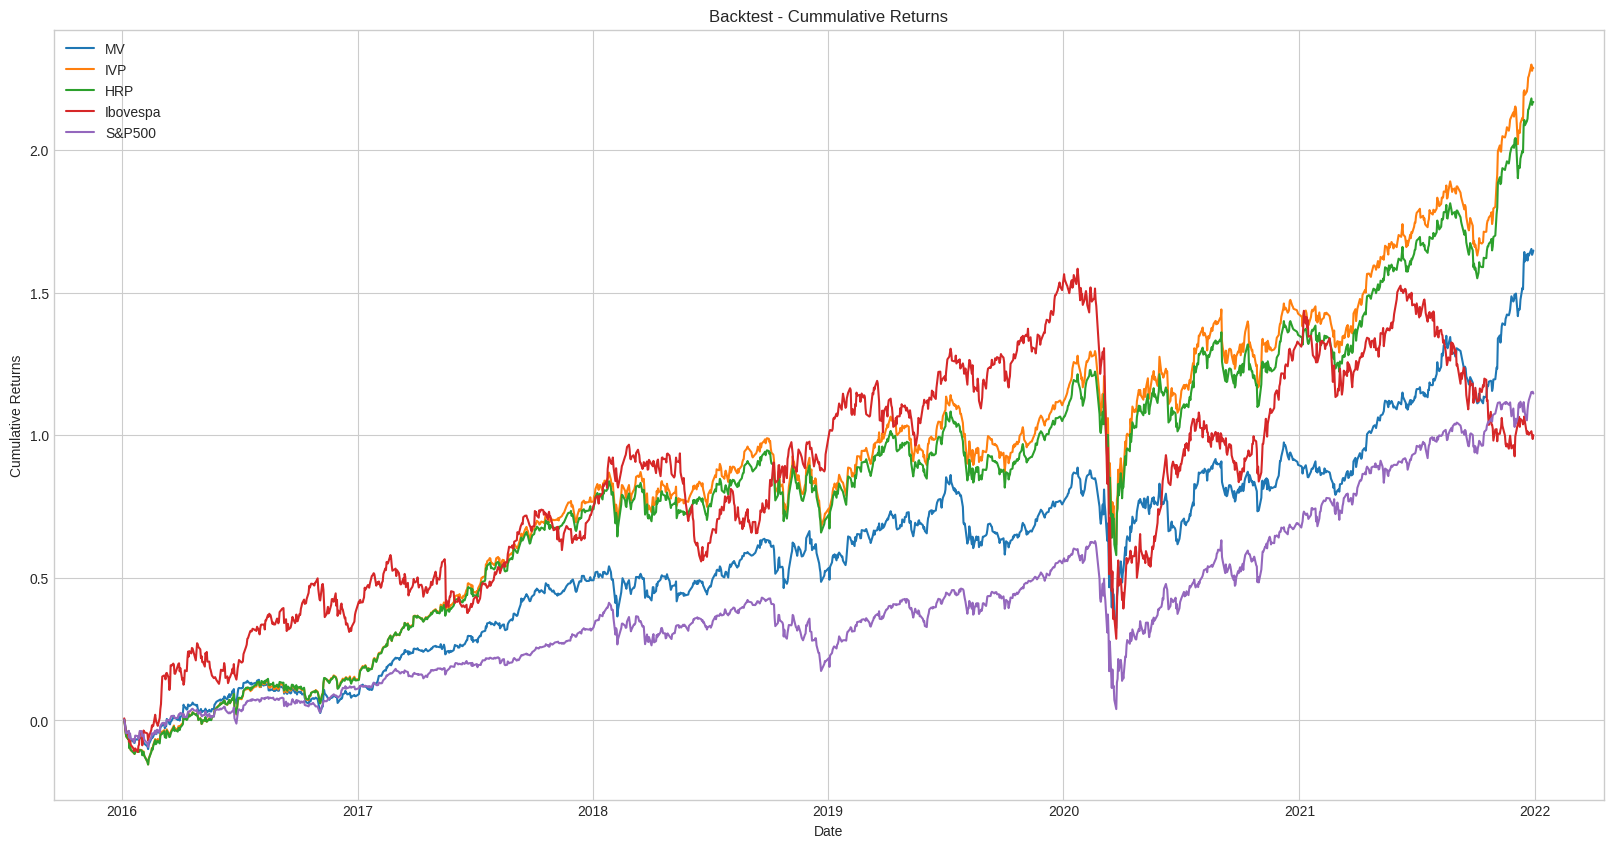

In [84]:
# Merge DataFrames Performances
df_performances_final = pd.merge(
        portfolio_methods_returns, cummulative_returns_benchs, left_index=True, right_index=True
    )

plot_returns(df_performances_final, "Backtest - Cummulative Returns", df_performances_final.columns)

## Monte Carlo Simulations of In-sample and Out-sample variances distributions

In [17]:
def sample_cov_matrix():
    return covar


def compute_portfolio_variance(weights, cov):
    return np.sum(np.array(weights).T.dot(cov * 252).dot(np.array(weights)))


def generate_returns_sample(covariances, horizon):
    return pd.DataFrame(
        np.random.multivariate_normal(
            np.zeros(len(covariances)), covariances, size=horizon
        )
    )

In [18]:
methods = {
    'MV': getMV,
    'IVP': getIVP,
    'HRP': getHRP,
}

In [19]:
def monte_carlo_experiment(simulations=10000):

    empirical_variances = {
        method: {"in-sample": [], "out-sample": []} for method in methods.keys()
    }

    experiments = simulations

    for test in tqdm(range(experiments)):

        true_covariances = sample_cov_matrix()
        in_sample = generate_returns_sample(true_covariances, horizon=260)
        out_sample = generate_returns_sample(true_covariances, horizon=260)

        for name, method in methods.items():

            in_sample_weights = method(in_sample.cov())

            in_sample_var = compute_portfolio_variance(
                in_sample_weights, in_sample.cov()
            )

            out_sample_var = compute_portfolio_variance(
                in_sample_weights, out_sample.cov()
            )

            empirical_variances[name]["in-sample"].append(in_sample_var)
            empirical_variances[name]["out-sample"].append(out_sample_var)

    for method, distribs in empirical_variances.items():

        plt.hist(
            distribs["in-sample"],
            bins=100,
            label="in-sample",
            alpha=0.7,
            color="darkgreen",
        )
        plt.hist(
            distribs["out-sample"], bins=100, label="out-sample", alpha=0.7, color="red"
        )
        plt.axvline(
            x=np.mean(distribs["in-sample"]),
            color="darkgreen",
            linestyle="dashed",
            linewidth=3,
        )
        plt.axvline(
            x=np.mean(distribs["out-sample"]),
            color="red",
            linestyle="dashed",
            linewidth=3,
        )
        plt.title(method, fontsize=15)
        plt.legend(loc=1, fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=15)
        plt.grid(True, linewidth=0.3, linestyle="-")
        sns.despine(left=True, bottom=True)
        plt.plot(figsize=(30, 24))
        plt.show()
        print("\n")

        print(
            method
            + ":\n"
            + "in-sample variance: "
            + str(round(np.mean(distribs["in-sample"]), 4))
            + "\n"
            + "out-sample variance: "
            + str(round(np.mean(distribs["out-sample"]), 4))
            + "\n"
            + "\n\n"
        )

100%|██████████| 10000/10000 [46:51<00:00,  3.56it/s]


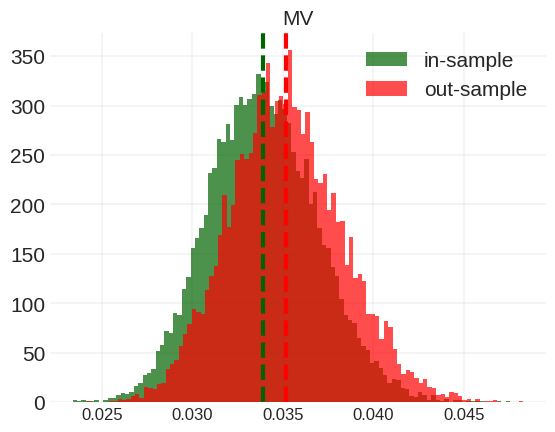



MV:
in-sample variance: 0.0339
out-sample variance: 0.0352





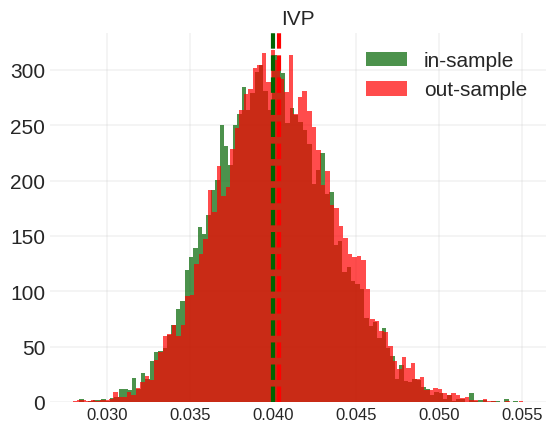



IVP:
in-sample variance: 0.04
out-sample variance: 0.0403





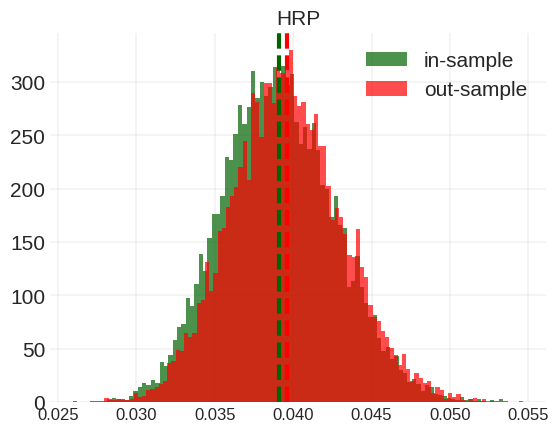



HRP:
in-sample variance: 0.0391
out-sample variance: 0.0396





In [89]:
mmc_in_out = monte_carlo_experiment(simulations=10000)
mmc_in_out

# *Long&Short* Strategy

In [71]:
class LongShortStrategy:
    def __init__(self, method, stocks_weights, sp500_beta, ibov_beta):
        self.stocks_returns, self.bench_returns = historical_data()
        self.ibov_returns = self.bench_returns.iloc[:, :1]
        self.sp500_returns = self.bench_returns.iloc[:, -1:]
        self.method = method
        self.stocks_weights = stocks_weights
        self.sp500_beta = float(sp500_beta)
        self.ibov_beta = float(ibov_beta)
        self.portfolio_returns = None
        self.portfolio_cum_returns = None
        self.annual_volatility = None
        self.max_drawdown = None
        self.sharpe_ratio = None
        self.correlation = None

    def run_strategy(self):
        # Long Portfolio
        portfolio_returns_long = pd.DataFrame(
            (stocks_returns * portfolios.T.loc[self.method]).sum(axis=1), columns=[self.method]
        )

        # Short Portfolio
        sp500_weights = self.sp500_beta / (self.sp500_beta + self.ibov_beta)
        ibov_weights = self.ibov_beta / (self.sp500_beta + self.ibov_beta)
        bench_weights = [ibov_weights, sp500_weights]

        # Short portfolio beta exposure
        short_portfolio_returns = pd.DataFrame(
            (bench_returns * bench_weights).sum(axis=1),
            columns=["Short Portfolio Returns"],
        )
        self.short_beta = (
            sp500_weights * self.sp500_beta + ibov_weights * self.ibov_beta
        )

        # Cummulative Returns
        self.portfolio_returns = pd.merge(
            portfolio_returns_long,
            short_portfolio_returns,
            left_index=True,
            right_index=True,
        )
        self.portfolio_returns[f"L&S - {self.method}"] = self.portfolio_returns.apply(
            lambda x: x[self.method] - x["Short Portfolio Returns"], axis=1
        )
        self.portfolio_cum_returns = indicators.calculate_cumulative_returns(
            self.portfolio_returns.filter(items=[f"L&S - {self.method}"])
        )

        # Annual Volatility
        self.annual_volatility = indicators.calculate_annual_volatility(
            self.portfolio_returns)
        

        # Maximum Drawdown
        self.max_drawdown = indicators.calculate_max_drawdown(
            self.portfolio_cum_returns
        )

        # Sharpe Ratio
        self.sharpe_ratio = indicators.calculate_sharpe_ratio(self.portfolio_returns)

        # Correlation
        df_returns = self.portfolio_returns.merge(
            self.bench_returns, how="inner", left_index=True, right_index=True
        )

        self.correlation = df_returns.corr()
    
        return self.portfolio_cum_returns[f"L&S - {self.method}"]

    def calculate_metrics(self):
        return pd.DataFrame(
            {
                f"Strategy L&S - {self.method}": [
                    "{:.2%}".format(self.portfolio_cum_returns[f"L&S - {self.method}"].iloc[-1]),
                    "{:.2%}".format(self.annual_volatility[f"L&S - {self.method}"]),
                    "{:.2%}".format(self.max_drawdown),
                    "{:.2}".format(self.sharpe_ratio[f"L&S - {self.method}"]),
                    "{:.2}".format(self.correlation.loc[f"L&S - {self.method}","S&P500"]),
                    "{:.2}".format(self.correlation.loc[f"L&S - {self.method}","Ibovespa"])
                ]
            },
            index=[
                "Cumulative Returns",
                "Annual Volatility",
                "Max Drawdown",
                "Sharpe Ratio",
                "Correlation L&S-S&P500",
                "Correlation L&S-Ibovespa"
            ],
        )

        # Calcula a correlação com os índices
        df_metrics = self.portfolio_returns.merge(
            self.bench_returns, how="inner", left_index=True, right_index=True
        )

    def plot_cumulative_returns(self):
        self.portfolio_cum_returns.plot(figsize=(12, 8))
        plt.title("Backtest L&S Strategy - Cumulative Returns")
        plt.xlabel("Date")
        plt.ylabel("Cummulative Returns")
        plt.show()

In [86]:
def calculte_LongShort_methods(methods, portfolios, performance):

    cummulative_returns_methods = pd.DataFrame()
    result_indicators = pd.DataFrame()

    for i in methods:

        # Class LongShortStrategy
        ls_strategy = LongShortStrategy(
            i,
            portfolios[i],
            performance[i]["Beta S&P500"],
            performance[i]["Beta Ibovespa"],
        )

        # Run strategy
        ls_cummulative_returns = ls_strategy.run_strategy()

        if cummulative_returns_methods.empty == True:
            cummulative_returns_methods = ls_cummulative_returns

        else:
            cummulative_returns_methods = pd.merge(
                cummulative_returns_methods,
                ls_cummulative_returns,
                left_index=True,
                right_index=True,
            )
            cummulative_returns_methods = pd.DataFrame(cummulative_returns_methods)

        # DataFrame Indicators
        indicators = ls_strategy.calculate_metrics()

        indicators_temp = indicators
        if result_indicators.empty == True:
            result_indicators = indicators_temp

        else:
            result_indicators = pd.merge(
                result_indicators,
                indicators_temp,
                left_index=True,
                right_index=True,
            )
            result_indicators = pd.DataFrame(result_indicators)

    return result_indicators, cummulative_returns_methods


In [87]:
result_indicators, cummulative_returns_methods = calculte_LongShort_methods(['MV','IVP','HRP'], portfolios, performance)
result_indicators

,Strategy L&S - MV,Strategy L&S - IVP,Strategy L&S - HRP
Cumulative Returns,15.26%,46.62%,40.76%
Annual Volatility,13.61%,12.56%,12.73%
Max Drawdown,-26.37%,-22.65%,-22.82%
Sharpe Ratio,0.029,0.35,0.3
Correlation L&S-S&P500,-0.26,-0.1,-0.14
Correlation L&S-Ibovespa,-0.55,-0.47,-0.48


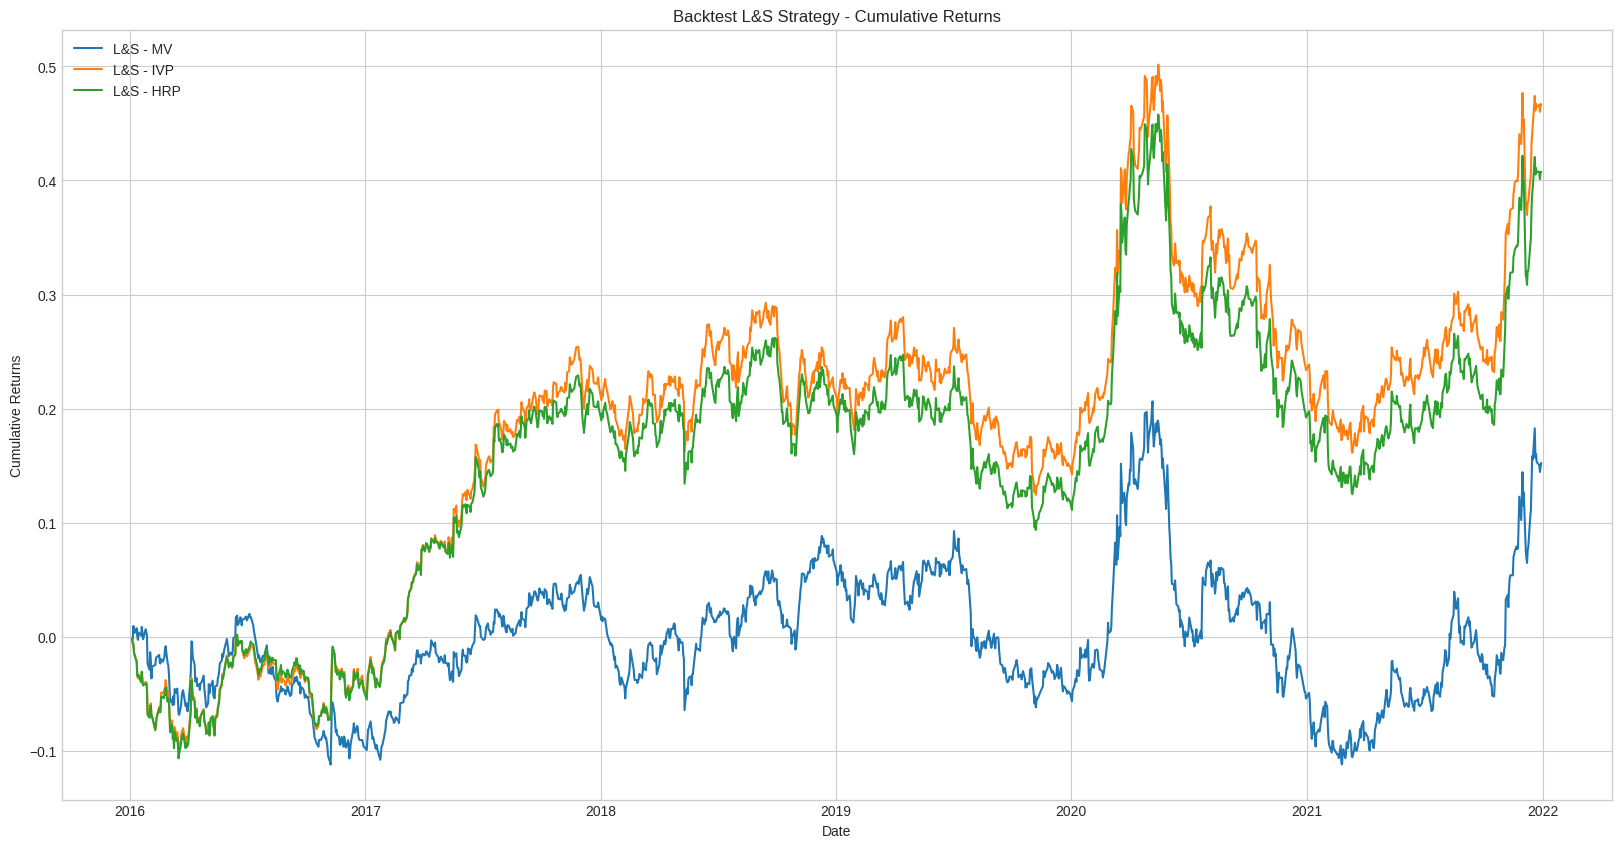

In [88]:
plot_returns(cummulative_returns_methods, "Backtest L&S Strategy - Cumulative Returns", cummulative_returns_methods.columns)